To-do:
1. Текст был очищен только от одного мусорного элемента в качестве примера. Исслудйте данные через ноутбук или чере веб-интерфейс BigQuery на предмет других мусорных элементов в тексте, которые не несут в себе никакого особого смысла, а только создают шум в данных. Доработайте функцию очистки тектосвых данных, чтобы в нее можно было передать список ненужного мусора и разом выполнялась очистка
2. Проведите стратифицировнную кросс-валидуцию нейросетевого классификатора https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
3. Поэксперементируйте с гиперпараметрами нейросетевого классификатора, постарайтесь повысить качество его работы
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
4. Попробуйте использовать не Word2Vec для получения векторого представления текста, а TF-IDF преобразование http://zabaykin.ru/?p=558 http://nlpx.net/archives/57
5. Попробуйте использовать более тонко настриваемые алгоритмы нейросетей, например из этого видео https://www.youtube.com/watch?v=cPkH1k3U1c8 

In [1]:
import warnings
warnings.filterwarnings('ignore')

from google.oauth2 import service_account
import pandas_gbq 

import numpy as np
import pandas as pd
import math as mt
import datetime as dt

from langdetect import detect
import re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report,confusion_matrix
from gensim.models.word2vec import Word2Vec
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

import string


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, MaxPooling1D, Conv1D, GlobalMaxPooling1D, Dropout, LSTM, GRU
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import utils

import os

In [2]:
CREDENTIALS = service_account.Credentials.from_service_account_info({
 
})

In [3]:
#funtion for getting fresh data from DWH for workload model
"""[summary]
Funtion for getting fresh data from BigQuery for workload scoring model
[description]
Credentials - google service account object with credentials data for project
[example]
Input: Credentials = credentials_object
Output: description	                                        channel	 category	category_flag
        \nChat transcript:\nVisitor: I want to buy wit...	chat	 ps	        1
        \nChat transcript:\nVisitor: hell i had a prob...	chat	 ps	        1
        \nChat transcript:\nVisitor: لا استطيع الشراء ...	 chat	  ps	     1
"""
def getDwhData(Credentials):
    statement_bigquery_sql = " ".join(["select description, channel, case",
                                       "when manual_category in ('payment_problem','how_to_pay','howtopay','how_to_play','paystation_error','ps_problem','ps_declined') then 'ps'",
                                       "else 'other'",
                                       "end as category,",
                                       "case",
                                       "when manual_category in ('payment_problem','how_to_pay','howtopay','how_to_play','paystation_error','ps_problem','ps_declined') then 0",
                                       "else 1",
                                       "end as category_flag",
                                       "from `xsolla_summer_school.customer_support`",
                                       "where manual_category is not null and",
                                       "manual_category <> '' and",
                                       "description is not null and",
                                       "description <> '' and",
                                       "channel is not null and",
                                       "channel <> '' and",
                                       "channel in ('chat','facebook')"])
    
    dataframe_bigquery = pandas_gbq.read_gbq(statement_bigquery_sql,project_id='findcsystem', credentials=Credentials, dialect='standard')

    return dataframe_bigquery


"""[summary]
Function for transform text to lower case
[description]
Corpus - list or array object, with text data
[example]
Input: Corpus = ["Text_1","Text_2"]
Output: ["text_1","text_2"]
"""
def lowerCase(Corpus):
    corpus = [i.lower().replace('\n','') for i in Corpus]
    return corpus


"""[summary]
Function for getting language of text
[description]
Corpus - list or array object, with text data
[example]
Input: Corpus = ["Text_1","Text_2"]
Output: ["en","ru"]
"""
def getTextLanguage(Corpus):
    txt_lang = []
    for txt in Corpus:
        try:
            lang = detect(txt)
            txt_lang.append(lang)
        except:
            lang = 'error'
            txt_lang.append(lang)
    
    return txt_lang


"""[summary]
Function for tokenization text
[description]
Corpus - list or array object, with text data
[example]
Input: Corpus = ["word1 word2","word3 word4"]
Output: [["word1","word2"],["word3","word4"]]
"""  
def textToTokens(Corpus):
    corpus = [i.split() for i in Corpus]
    return corpus 


"""[summary]
Function for clear text after garbage
[description]
Corpus - list or array object, with text data
Substr - string, regular expression
[example]
Input: Corpus = [["word1","word2"],["word3","word4"]]
       Substr = r'word1
Output: [["word2"],["word3","word4"]]
"""  
def clearTextAfterGarbage(Corpus,SubstrList):
    clear_corpus = []
    for text in Corpus:
        indexes = []
        text_len = len(text)
        try:
            for substr in SubstrList:
                for i in range(0,text_len):               
                    res = re.search(substr,text[i])
                    if res != None:
                        indexes.append(i)
                
            #delete garbage word from text
            for index in indexes:
                del text[index]
        
            clear_corpus.append(text)
        except:
            clear_corpus.append("error")
        
    return clear_corpus



"""[summary]
Build word vector by using pre-trained Word2Vec model
[description]
Size - lenght of vector
Word2Vec_Model - gensim object
"""  
def buildWordVector(Text,Size,Word2Vec_Model):
    vec = np.zeros(Size).reshape((1,Size))
    count = 0.

    for word in Text:
        try:
            vec += Word2Vec_Model[word].reshape((1,Size))
            count += 1.
        except KeyError:
            continue
    
    if count != 0:
        vec /= count
    
    return vec



#-------------------------------------------
'''
Функция удаления знаков препинания из строки

def delPunctuation(sentList):
    res_list=[]
    for item in sentList:
        tt = str.maketrans(dict.fromkeys(string.punctuation))
        res_sentence = item.translate(tt)
        res_list.append(res_sentence)
    return res_list 
'''


'''
Функция разделения на слова
На вход: список сообщений
На выходе: список, элементы которого - списки слов в сообщении
'''
def textToTokensNew(corpus):
    res_corpus = [nltk.word_tokenize(i) for i in corpus]
    return res_corpus 

'''
Функция удаления мусора - удаляет слова по шаблону

'''
def clearTextAfterGarbageNew(texts,garbage_list):
    clear_corpus=[]
    for text in texts:
        clear_text = []
        indexes = []
        text_len = len(text)
        try:       
            for substr in garbage_list:
                for i in range(0,text_len):
                    res = re.search(substr,text[i])
                    if res != None:
                        indexes.append(i)        
            for i in range(0,text_len):
                if i not in indexes:
                    clear_text.append(text[i])
            clear_corpus.append(clear_text)
        except Exception as e:
            clear_corpus.append(str(e))
    return clear_corpus


'''
Функция удаления стоп-слов и знаков пунктуации - удаляет конкретные элементы из списка слов
'''
def delStopWords(texts,stop_list):
    clear_corpus=[]
    for text in texts:
        clear_text = []
        text_len = len(text)
        for i in range(0,text_len):
            if text[i] not in stop_list:
                clear_text.append(text[i])
        clear_corpus.append(clear_text)
    return clear_corpus  

'''
Лемматизация слов
'''
def lemmatizeText(texts):
    lemmatizer = WordNetLemmatizer()
    corpus=[]
    for text in texts:
        lem_text = []
        text_len = len(text)
        for i in range(0,text_len):
            lem_text.append(lemmatizer.lemmatize(text[i]))
        corpus.append(lem_text)
    return corpus  

RAWDATA 

In [4]:
#getting data from dwh
SupportRawDataframe = getDwhData(CREDENTIALS)
SupportRawDataframe.shape

Downloading: 100%|███████████████████████████████████████████████████████████| 23450/23450 [00:10<00:00, 2296.43rows/s]


(23450, 4)

In [5]:
SupportRawDataframe.head(10)

,description,channel,category,category_flag
0,\nChat transcript:\nVisitor: I want to buy wit...,chat,ps,0
1,\nChat transcript:\nVisitor: hell i had a prob...,chat,ps,0
2,\nChat transcript:\nVisitor: لا استطيع الشراء ...,chat,ps,0
3,\nChat transcript:\nVisitor: im having trouble...,chat,ps,0
4,\nChat transcript:\nVisitor: Hi\nAna: Hello. H...,chat,ps,0
5,\nChat transcript:\nVisitor: Здраствуйте\nAna:...,chat,ps,0
6,\nChat transcript:\nVisitor: hello\nVisitor: w...,chat,ps,0
7,\nChat transcript:\nVisitor: not letting me bu...,chat,ps,0
8,\nChat transcript:\nVisitor: مرحبا\nAna: Hello...,chat,ps,0
9,\nChat transcript:\nVisitor: hi im trying to b...,chat,ps,0


In [6]:
SupportRawDataframe.tail(10)

,description,channel,category,category_flag
23440,"\nChat transcript:\nVisitor: Hello, I bought p...",chat,other,1
23441,\nChat transcript:\nVisitor: Good day\n\nI acc...,facebook,other,1
23442,\nChat transcript:\nVisitor: payment not going...,chat,other,1
23443,\nChat transcript:\nVisitor: Paid for faceit s...,chat,other,1
23444,"\nChat transcript:\nVisitor: Hello, I am tryin...",chat,other,1
23445,"\nChat transcript:\nVisitor: Hi, i made a pruc...",chat,other,1
23446,"\nChat transcript:\nVisitor: Hi, how long will...",chat,other,1
23447,\nChat transcript:\nVisitor: I bought playerun...,chat,other,1
23448,\nChat transcript:\nVisitor: Good day i took t...,chat,other,1
23449,\nChat transcript:\nVisitor: hi\nVisitor: hell...,chat,other,1


# DATA PREPROC

In [7]:
#transform text to lower case
corpus = SupportRawDataframe.description
corpus.astype('str')

corpus = lowerCase(corpus)

#getting language for text corpus
corpus_lang = getTextLanguage(corpus)

In [8]:
corpus_lang

['en',
 'en',
 'en',
 'en',
 'en',
 'ru',
 'en',
 'en',
 'en',
 'en',
 'es',
 'en',
 'en',
 'en',
 'es',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'ru',
 'ru',
 'en',
 'en',
 'en',
 'en',
 'ru',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'es',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'de',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'ru',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'ru',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'ru',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'ru',
 'en',
 'en',
 'en',
 'en',
 'en',
 'ru',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'en',
 'th',
 'en',
 'en',
 'en',

In [9]:
#new dataframe with texts in lower case, without /n symbol and with lang for text
SupportRawDataframe['description'] = corpus
SupportRawDataframe['lang'] = corpus_lang

In [10]:
SupportRawDataframe.head(10)

,description,channel,category,category_flag,lang
0,chat transcript:visitor: i want to buy with pa...,chat,ps,0,en
1,chat transcript:visitor: hell i had a problem ...,chat,ps,0,en
2,chat transcript:visitor: لا استطيع الشراء ومعل...,chat,ps,0,en
3,chat transcript:visitor: im having trouble wit...,chat,ps,0,en
4,chat transcript:visitor: hiana: hello. how can...,chat,ps,0,en
5,chat transcript:visitor: здраствуйтеana: здрав...,chat,ps,0,ru
6,chat transcript:visitor: hellovisitor: why i c...,chat,ps,0,en
7,chat transcript:visitor: not letting me buy an...,chat,ps,0,en
8,chat transcript:visitor: مرحباana: hello!visit...,chat,ps,0,en
9,chat transcript:visitor: hi im trying to buy v...,chat,ps,0,en


In [11]:
SupportRawDataframe.tail(10)

,description,channel,category,category_flag,lang
23440,"chat transcript:visitor: hello, i bought pubg ...",chat,other,1,en
23441,chat transcript:visitor: good dayi accidentall...,facebook,other,1,en
23442,chat transcript:visitor: payment not going thr...,chat,other,1,en
23443,chat transcript:visitor: paid for faceit subsc...,chat,other,1,en
23444,"chat transcript:visitor: hello, i am trying to...",chat,other,1,en
23445,"chat transcript:visitor: hi, i made a pruchase...",chat,other,1,en
23446,"chat transcript:visitor: hi, how long will it ...",chat,other,1,en
23447,chat transcript:visitor: i bought playerunknow...,chat,other,1,en
23448,chat transcript:visitor: good day i took the w...,chat,other,1,en
23449,chat transcript:visitor: hivisitor: hellovisit...,chat,other,1,en


In [12]:
#getting only en texts
SupportDataframe_eng = SupportRawDataframe[SupportRawDataframe.lang == 'en'][:]
SupportDataframe_eng.head()

,description,channel,category,category_flag,lang
0,chat transcript:visitor: i want to buy with pa...,chat,ps,0,en
1,chat transcript:visitor: hell i had a problem ...,chat,ps,0,en
2,chat transcript:visitor: لا استطيع الشراء ومعل...,chat,ps,0,en
3,chat transcript:visitor: im having trouble wit...,chat,ps,0,en
4,chat transcript:visitor: hiana: hello. how can...,chat,ps,0,en


# Токенизация сообщений
В функции textToTokensNew решил воспользоваться токенизатором из библиотеки nltk - вроде производит разбиение более "умным" способом

In [13]:
tokenization = textToTokensNew(SupportDataframe_eng.description)

In [14]:
SupportDataframe_eng_token = SupportDataframe_eng[:]
SupportDataframe_eng_token['description'] = tokenization
SupportDataframe_eng_token.head()

,description,channel,category,category_flag,lang
0,"[chat, transcript, :, visitor, :, i, want, to,...",chat,ps,0,en
1,"[chat, transcript, :, visitor, :, hell, i, had...",chat,ps,0,en
2,"[chat, transcript, :, visitor, :, لا, استطيع, ...",chat,ps,0,en
3,"[chat, transcript, :, visitor, :, im, having, ...",chat,ps,0,en
4,"[chat, transcript, :, visitor, :, hiana, :, he...",chat,ps,0,en


# Удаление мусорных слов
Удаляем слова по шаблону. Затем удаляем конкретные элементы, которые при токенизации определились как отдельные слова - знаки преписания, числа, стоп-слова

In [15]:
texts = list(SupportDataframe_eng_token.description)
#cleaning text after garbage
garbage_list = [r'chat',r'transcript',r'visitor',r'https*',r'access_token*',r'www*',r'\/\/secure\.xsolla\.com*',
                r'url*',r'\d+\.\d+','^[-+]?[0-9]+$',r'preferences*',r'sessional*',r'additional*']

In [16]:
texts_clear=clearTextAfterGarbageNew(texts,garbage_list)
SupportDataframe_eng_token['description'] = texts_clear
SupportDataframe_eng_token.head()

,description,channel,category,category_flag,lang
0,"[:, :, i, want, to, buy, with, paypal, and, sh...",chat,ps,0,en
1,"[:, :, hell, i, had, a, problem, yesterday, ab...",chat,ps,0,en
2,"[:, :, لا, استطيع, الشراء, ومعلومات, الشراء, ص...",chat,ps,0,en
3,"[:, :, im, having, trouble, with, the, new, xs...",chat,ps,0,en
4,"[:, :, hiana, :, hello, ., how, can, i, help, ...",chat,ps,0,en


In [17]:
stop_list=list(string.punctuation)+['’','``',"''"]+stopwords.words('english')
texts=list(SupportDataframe_eng_token.description)

In [18]:
texts_clear_stop = delStopWords(texts,stop_list)
SupportDataframe_eng_token['description'] = texts_clear_stop
SupportDataframe_eng_token.head()

,description,channel,category,category_flag,lang
0,"[want, buy, paypal, show, problem, call, helpa...",chat,ps,0,en
1,"[hell, problem, yesterday, subscribing, people...",chat,ps,0,en
2,"[لا, استطيع, الشراء, ومعلومات, الشراء, صحيحة, ...",chat,ps,0,en
3,"[im, trouble, new, xsolla, auth, digit, code, ...",chat,ps,0,en
4,"[hiana, hello, help, ca, n't, pay, paypal, bec...",chat,ps,0,en


# Лемматизация
В функции lemmatizeText воспользовался лемматизатором WordNet из библиотеки nltk. Насколько заметил, работает не очень хорошо (например, не различает формы глагола be), но судя по описанию является базовым. Возможно стоило воспользоваться spacy.

In [19]:
texts=list(SupportDataframe_eng_token.description)

In [20]:
text_lemmatized=lemmatizeText(texts)
SupportDataframe_eng_token['description'] = texts_clear_stop
SupportDataframe_eng_token.reset_index(drop=True,inplace=True)
SupportDataframe_eng_token.head(10)

,description,channel,category,category_flag,lang
0,"[want, buy, paypal, show, problem, call, helpa...",chat,ps,0,en
1,"[hell, problem, yesterday, subscribing, people...",chat,ps,0,en
2,"[لا, استطيع, الشراء, ومعلومات, الشراء, صحيحة, ...",chat,ps,0,en
3,"[im, trouble, new, xsolla, auth, digit, code, ...",chat,ps,0,en
4,"[hiana, hello, help, ca, n't, pay, paypal, bec...",chat,ps,0,en
5,"[cant, pay, whit, mobile, phone, ana, hello, h...",chat,ps,0,en
6,"[letting, buy, anythingana, hello, ana, please...",chat,ps,0,en
7,"[مرحباana, hello, hi, problem, try, credit, ca...",chat,ps,0,en
8,"[hi, im, trying, buy, v, bucks, wont, let, pay...",chat,ps,0,en
9,"[hi, tried, robux, could, n't, could, fix, ana...",chat,ps,0,en


# TRAIN TEST SPLIT DATAFRAMES

In [21]:
#list of unique categories
unique_categories = np.unique(SupportDataframe_eng_token.category)
unique_categories

array(['other', 'ps'], dtype=object)

In [22]:
descriptions = SupportDataframe_eng_token['description']
categories = SupportDataframe_eng_token['category_flag']
XTrain,XTest,YTrain,YTest = train_test_split(descriptions,
                                             categories,
                                             stratify = categories,
                                             test_size = 0.2,
                                             random_state = 40)
XTrain

14623    [hi, n't, gotten, email, download, links, late...
1384               [try, cash, said, could, n't, complete]
11071    [hello, got, money, back, im, trying, give, su...
8256     [hello, game, paid, yetismael, hello, wait, mi...
7035     [cny, invoice, help, go, support.xsolla.com, m...
                               ...                        
10954    [get, transactions, dont, know, companyhailey,...
10802    [hye, faceit, account, bugged, sad, platform, ...
13650    [hello, ordered, order, twice, mistake, meant,...
7961     [hellokate, hello., br, help, hey, bought, fac...
11927                                    [pay, dont, paid]
Name: description, Length: 12808, dtype: object

# FROM TEXTS TO VECTORS

In [23]:
#initialize Word2Vec model for embedding words to vectors
NDim = 100
Imdb_w2v = Word2Vec(size = NDim,min_count = 10)
Imdb_w2v.build_vocab(XTrain)

In [24]:
Imdb_w2v.train(XTrain,total_examples = Imdb_w2v.corpus_count,epochs = Imdb_w2v.epochs)

(4377374, 5882625)

In [25]:
#embedding training messages to vectors for neutral classifier
TrainVecs = np.concatenate([buildWordVector(i,NDim,Imdb_w2v) for i in XTrain])

In [26]:
TrainVecs

array([[-1.23104631e-01,  4.91798125e-01,  1.91932174e-01, ...,
        -3.15249281e-01,  2.76580839e-01, -6.22653307e-01],
       [-1.27562493e+00,  5.82637005e-02,  6.88607484e-01, ...,
        -7.20071964e-01,  1.76240171e-01, -1.71088524e-01],
       [-3.76340518e-01,  7.46680992e-01,  3.77825516e-01, ...,
        -4.80101072e-01,  5.73375082e-01, -1.35178115e-01],
       ...,
       [-1.31791856e-01,  3.35577610e-01, -6.79540119e-01, ...,
         1.34929811e-01, -4.25526875e-02, -2.16958027e-01],
       [-8.69563688e-01,  2.58658197e-01,  8.86091995e-05, ...,
        -2.46739736e-01,  2.84848508e-01, -4.78883578e-01],
       [-4.04607465e-01,  7.73205429e-01,  4.54282282e-01, ...,
        -3.53563865e-01,  4.82552995e-02,  5.79886041e-01]])

In [27]:
Imdb_w2v.train(XTest, total_examples = Imdb_w2v.corpus_count, epochs = Imdb_w2v.epochs)

(1073823, 1448330)

In [28]:
TestVecs = np.concatenate([buildWordVector(i,NDim,Imdb_w2v) for i in XTest])

In [29]:
TestVecs

array([[-0.11295016,  0.26127912,  0.04197748, ..., -0.18094712,
         0.28111163, -0.22550091],
       [-0.46365241,  0.18471313, -0.15462654, ...,  0.25493947,
        -0.4632596 ,  0.051032  ],
       [-0.19258073,  0.97492683,  0.24663282, ..., -0.26438011,
         0.15378889,  0.1951804 ],
       ...,
       [-0.14041364,  0.59760409,  0.30607393, ..., -0.27824325,
         0.19848602, -0.25878543],
       [-0.76045037,  0.9527395 ,  0.05381944, ..., -0.0902425 ,
         0.18886009, -0.24629295],
       [-0.92644945,  0.58361932,  0.26034646, ...,  0.13256367,
         0.18150464, -0.15761314]])

# CROSSVALIDATION AND BUILD CLASSIFIER

In [30]:
TextClassifier = MLPClassifier(hidden_layer_sizes = (20,10), max_iter = 1000, random_state = 40)
TextClassifier

MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=1000, random_state=40)

In [31]:
Scores = cross_val_score(TextClassifier, TrainVecs, YTrain, cv = 5)
print(Scores)
print(np.mean(Scores))

[0.89422326 0.90163934 0.90124902 0.8965248  0.89105818]
0.8969389213876191


In [32]:
TextClassifier.fit(TrainVecs,YTrain)

MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=1000, random_state=40)

In [33]:
pred = TextClassifier.predict(TestVecs)
print(confusion_matrix(YTest,pred))
print(classification_report(YTest,pred))

[[ 440  197]
 [ 448 2118]]
              precision    recall  f1-score   support

           0       0.50      0.69      0.58       637
           1       0.91      0.83      0.87      2566

    accuracy                           0.80      3203
   macro avg       0.71      0.76      0.72      3203
weighted avg       0.83      0.80      0.81      3203



# Стратифицированная кросс-валидация

In [34]:
descriptions = SupportDataframe_eng_token['description']
categories = SupportDataframe_eng_token['category_flag']

ss = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)

for train_index, test_index in ss.split(descriptions, categories):
    XTrain, XTest = descriptions[train_index], descriptions[test_index]
    YTrain, YTest = categories[train_index], categories[test_index]  


In [35]:
#initialize Word2Vec model for embedding words to vectors
NDim = 100
Imdb_w2v = Word2Vec(size = NDim,min_count = 10)
Imdb_w2v.build_vocab(XTrain)

Imdb_w2v.train(XTrain,total_examples = Imdb_w2v.corpus_count,epochs = Imdb_w2v.epochs)

#embedding training messages to vectors for neutral classifier
TrainVecs = np.concatenate([buildWordVector(i,NDim,Imdb_w2v) for i in XTrain])

Imdb_w2v.train(XTest, total_examples = Imdb_w2v.corpus_count, epochs = Imdb_w2v.epochs)

TestVecs = np.concatenate([buildWordVector(i,NDim,Imdb_w2v) for i in XTest])


In [36]:
TextClassifier = MLPClassifier(hidden_layer_sizes = (20,10), max_iter = 1000, random_state = 40)

Scores = cross_val_score(TextClassifier, TrainVecs, YTrain, cv = ss)
print(Scores)
print(np.mean(Scores))

TextClassifier.fit(TrainVecs,YTrain)

pred = TextClassifier.predict(TestVecs)
print(confusion_matrix(YTest,pred))
print(classification_report(YTest,pred))

[0.89149102 0.89812646 0.90163934 0.89656518 0.89262007]
0.8960884168673134
[[ 282  354]
 [ 281 2285]]
              precision    recall  f1-score   support

           0       0.50      0.44      0.47       636
           1       0.87      0.89      0.88      2566

    accuracy                           0.80      3202
   macro avg       0.68      0.67      0.67      3202
weighted avg       0.79      0.80      0.80      3202



# TF-IDF преобразование

In [37]:
support_dataframe_tf_idf = SupportDataframe_eng_token.copy()
SupportDataframe_eng_token.head()

,description,channel,category,category_flag,lang
0,"[want, buy, paypal, show, problem, call, helpa...",chat,ps,0,en
1,"[hell, problem, yesterday, subscribing, people...",chat,ps,0,en
2,"[لا, استطيع, الشراء, ومعلومات, الشراء, صحيحة, ...",chat,ps,0,en
3,"[im, trouble, new, xsolla, auth, digit, code, ...",chat,ps,0,en
4,"[hiana, hello, help, ca, n't, pay, paypal, bec...",chat,ps,0,en


In [38]:
support_dataframe_tf_idf['description']=support_dataframe_tf_idf['description'].apply(lambda x: ' '.join(x))
support_dataframe_tf_idf.head(10)

support_dataframe_tf_idf = support_dataframe_tf_idf.drop(support_dataframe_tf_idf[support_dataframe_tf_idf['description']==''].index)





In [39]:
descriptions = support_dataframe_tf_idf['description']
categories = support_dataframe_tf_idf['category_flag']

XTrain_tfidf,XTest_tfidf,YTrain_tfidf,YTest_tfidf = train_test_split(descriptions,
                                                                    categories,
                                                                    stratify = categories,
                                                                    test_size = 0.2,
                                                                    random_state = 40)


In [40]:
text_clf = Pipeline([
                     ('tfidf', TfidfVectorizer()),
                     ('clf', RandomForestClassifier())
                     ])
 
text_clf.fit(XTrain_tfidf, YTrain_tfidf)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])

In [41]:
pred_tfidf = text_clf.predict(XTest_tfidf)
print(confusion_matrix(YTest_tfidf,pred_tfidf))
print(classification_report(YTest_tfidf,pred_tfidf))

[[ 351  284]
 [  53 2508]]
              precision    recall  f1-score   support

           0       0.87      0.55      0.68       635
           1       0.90      0.98      0.94      2561

    accuracy                           0.89      3196
   macro avg       0.88      0.77      0.81      3196
weighted avg       0.89      0.89      0.89      3196



# Попытка улучшения
Попробуем сбалансировать количество элементов в каждом из классов

Воспользуемся наборами, которые были получены при стратифицированной кроссвалидации векторизированных сообщений

Oversampling - bибыточная выборка:

In [42]:
SMT = SMOTE(random_state = 42)
XTrain_SMOTE,YTrain_SMOTE = SMT.fit_sample(TrainVecs,YTrain)

TextClassifier = MLPClassifier(hidden_layer_sizes = (20,10), max_iter = 1000, random_state = 42)

Scores = cross_val_score(TextClassifier, TrainVecs, YTrain, cv = ss)
print(Scores)
print(np.mean(Scores))

TextClassifier.fit(TrainVecs,YTrain)

pred = TextClassifier.predict(TestVecs)
print(confusion_matrix(YTest,pred))
print(classification_report(YTest,pred))

[0.8969555  0.89929742 0.90437158 0.89773614 0.89496291]
0.8986647121705789
[[ 419  217]
 [ 204 2362]]
              precision    recall  f1-score   support

           0       0.67      0.66      0.67       636
           1       0.92      0.92      0.92      2566

    accuracy                           0.87      3202
   macro avg       0.79      0.79      0.79      3202
weighted avg       0.87      0.87      0.87      3202



Undesampling - уменьшение выборки

In [43]:
RUS = RandomUnderSampler(random_state = 40)
XTrain_RUS,YTrain_RUS = RUS.fit_sample(TrainVecs,YTrain)

TextClassifier = MLPClassifier(hidden_layer_sizes = (20,10), max_iter = 1000, random_state = 43)

Scores = cross_val_score(TextClassifier, TrainVecs, YTrain, cv = ss)
print(Scores)
print(np.mean(Scores))

TextClassifier.fit(TrainVecs,YTrain)

pred = TextClassifier.predict(TestVecs)
print(confusion_matrix(YTest,pred))
print(classification_report(YTest,pred))



[0.90398126 0.89812646 0.89461358 0.8989071  0.89574385]
0.8982744530718234
[[ 359  277]
 [ 169 2397]]
              precision    recall  f1-score   support

           0       0.68      0.56      0.62       636
           1       0.90      0.93      0.91      2566

    accuracy                           0.86      3202
   macro avg       0.79      0.75      0.77      3202
weighted avg       0.85      0.86      0.86      3202



Если все было сделано верно, то эксперимент не удался - точность определения элементов класса не улучшилась

# Нейроночка
пример решения задачи классификации сверточной нейронной сетью

In [66]:
df_mess = support_dataframe_tf_idf.copy()
df_mess.head()

,description,channel,category,category_flag,lang
0,want buy paypal show problem call helpana hell...,chat,ps,0,en
1,hell problem yesterday subscribing people got ...,chat,ps,0,en
2,لا استطيع الشراء ومعلومات الشراء صحيحة ميه بال...,chat,ps,0,en
3,im trouble new xsolla auth digit code making p...,chat,ps,0,en
4,hiana hello help ca n't pay paypal becouse n't...,chat,ps,0,en


Разбиваем данные на тренировочную и тестовую выборки

In [67]:
descriptions = SupportDataframe_eng_token['description']
categories = SupportDataframe_eng_token['category_flag']

XTrain,XTest,YTrain,YTest = train_test_split(descriptions,
                                             categories,
                                             stratify = categories,
                                             test_size = 0.2,
                                             random_state = 40)

Ограничения на исходные данные

In [68]:
# Максимальное количество слов 
num_words = 10000
# Максимальная длина новости
max_news_len = 150
# Количество классов новостей
nb_classes = 2


Выделяем правильные ответы

In [69]:
y_train = utils.to_categorical(YTrain, nb_classes)
y_train

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

Создаем токенизатор

In [70]:
tokenizer = Tokenizer(num_words=num_words)

Обучаем токенизатор на тренировочном наборе

In [49]:
tokenizer.fit_on_texts(XTrain)

In [71]:
tokenizer.word_index

{}

Преобразуем текст в числовые значения

In [51]:
sequences = tokenizer.texts_to_sequences(XTrain)

In [72]:
index = 1
print(XTrain[index])
print(sequences[index])

['hell', 'problem', 'yesterday', 'subscribing', 'people', 'got', 'refund', 'tried', 'subscribe', 'times', 'got', 'refund', 'nick28t', 'gifted', 'sub', 'channel', 'says', 'subscriber', 'anymoreana', 'hello', 'ana', 'mean', 'twitch', 'subscriptions', 'yesana', 'could', 'please', 'provide', 'us', 'e-mail', 'linked', 'twitch', 'account', 'thank', '.uk', 'spoke', 'yesterdayana', 'please', 'stand', 'online', 'may', 'take', 'time', 'resolve', 'issue', 'thank', 'patience', "'ll", 'provide', 'update', 'okay', 'thanksana', 'according', 'system', 'credited', 'balance', 'twitch', 'account', 'redeem', 'balance', 'partly', 'fully', 'next', 'payment', 'twitch', 'order', 'please', 'choose', 'subscription', 'tier', 'period', 'payment', 'option', 'click', 'pay', 'see', 'deducted', 'price', 'subscription.thank', 'okay', 'thanksana', 'anything', 'else', 'help', 'nope', 'thats', 'thanksana', 'thank', 'contacting', 'us', 'nice', 'day']
[48, 258, 191, 28, 25, 204]


Ограничиваем длину текстов

In [53]:
x_train = pad_sequences(sequences, maxlen=max_news_len)

In [73]:
x_train[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  103,
          25, 1083,    9,  569, 1977,  386,  706, 1133,  720,   11,    9,
         297,   16,   74,   30,  115,   13,    1,   20,   91,   59,   82,
           2,  297,   36,  219,    7,   57,  297, 1977,  569, 7005,  409,
        1881,  706, 1706,  213, 2240,  855,   33,   21,  721,  569, 1321,
          13,  389,  327,   48,  329, 

Создаем сверточную нейронную сеть

In [74]:
model_cnn = Sequential()
model_cnn.add(Embedding(num_words, 100, input_length=max_news_len))
model_cnn.add(Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(2, activation='softmax'))

In [56]:
model_cnn.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [75]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 146, 250)          125250    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32128     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 258       
Total params: 1,157,636
Trainable params: 1,157,636
Non-trainable params: 0
_________________________________________________________________


Создаем callback для сохранения нейронной сети на каждой эпохе, если качество работы на проверочном наборе данных улучшилось. Сеть сохраняется в файл best_model.h5

In [58]:
model_cnn_save_path = r'C:\Users\HomePC\Python Notebooks\Школа Xsolla 2020\Занятие 6 (14.08)\best_model_cnn.h5'


checkpoint_callback_cnn = ModelCheckpoint(model_cnn_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

Обучаем модель

In [59]:
history_cnn = model_cnn.fit(x_train, 
                            y_train, 
                            epochs=5,
                            batch_size=128,
                            validation_split=0.1,
                            callbacks=[checkpoint_callback_cnn])

Train on 11527 samples, validate on 1281 samples
Epoch 1/5
11527/11527 [==============================] - 33s 3ms/sample - loss: 0.3326 - acc: 0.8558 - val_loss: 0.2146 - val_acc: 0.9149
Epoch 2/5
11527/11527 [==============================] - 32s 3ms/sample - loss: 0.1811 - acc: 0.9279 - val_loss: 0.2001 - val_acc: 0.9243
Epoch 3/5
11527/11527 [==============================] - 33s 3ms/sample - loss: 0.1203 - acc: 0.9558 - val_loss: 0.2172 - val_acc: 0.9180
Epoch 4/5
11527/11527 [==============================] - 33s 3ms/sample - loss: 0.0719 - acc: 0.9742 - val_loss: 0.2570 - val_acc: 0.9196
Epoch 5/5
11527/11527 [==============================] - 32s 3ms/sample - loss: 0.0457 - acc: 0.9855 - val_loss: 0.3187 - val_acc: 0.8954


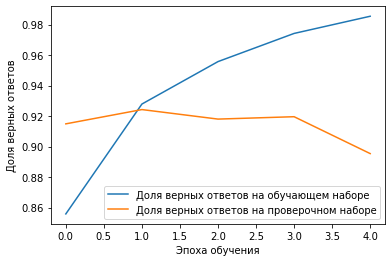

In [60]:
plt.plot(history_cnn.history['acc'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_acc'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Тестирование сети
Аналогичным образом работаем с тестовыми данными (используем уже ранее обученный токенизатор)

In [61]:
test_sequences = tokenizer.texts_to_sequences(XTest)

In [62]:
x_test = pad_sequences(test_sequences, maxlen=max_news_len)

In [63]:
x_test[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  103,
         505,   97,  323,  357,  814, 2010,  409,   32,    9,  294,    3,
           9,    6, 1336, 1010,   29,  293,  484,   10,  385,   12, 1551,
        1448,   84,   25, 1077, 6981, 

In [64]:
y_test = utils.to_categorical(YTest, nb_classes)

In [65]:
model_cnn.load_weights(model_cnn_save_path)

OSError: 

In [ ]:
model_cnn.evaluate(x_test, y_test, verbose=1)